In [1]:
import torch
from src.module2graph import GraphInterperterWithGamma
from src.resnet18 import ResNet18
import numpy as np

import graphviz
import itertools
import copy

import networkx as nx
from tqdm.auto import tqdm
from typing import Tuple, Dict # actually we don't need it for py>=3.9, but I have 3.8 on my laptop
#from numba import njit


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
resnet = ResNet18()
warp = GraphInterperterWithGamma(resnet)

Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/opt/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/opt/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/opt/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [3]:
named_dict = dict(resnet.named_modules())

for node in warp.graph.nodes:
    if node.op == 'call_module':
        pass
        # print('Norm', np.sqrt(sum([(p ** 2).sum().item() \
        #                            for p in named_dict[node.target].parameters()])))
    # print(node.op, node.name, node.args)
    # break
    

In [4]:
def module_to_graph(m: torch.nn.Module):
    graph = torch.fx.symbolic_trace(m).graph
    named_dict = dict(m.named_modules())
    edges = [] # (from, to)
    weights = {'x': 0} # node: params
    for node in graph.nodes:
        # no placeholder and call_mathod
        if node.op == 'call_module':
            n_params = sum([p.numel() for p in named_dict[node.target].parameters()])
            weights[node.name] = n_params
            assert len(node.args) == 1
            for arg in node.args:
                if type(arg) == torch.fx.Node:  # ignore constants
                    edges.append((arg.name, node.name))
        elif node.op == 'call_function':
            for arg in node.args:
                if type(arg) == torch.fx.Node:  # ignore constants
                    edges.append((arg.name, node.name))
            weights[node.name] = 0
        elif node.op == 'output':
            try:
                edges.append((node.args[0][0].name, node.name))
            except:
                edges.append((node.args[0].name, node.name))
            weights['output'] = 0
            
    return edges, {'_'.join(k.split('.')): v for k, v in weights.items()}

def forward_with_gammas(model, gammas: Dict[Tuple[str, str], torch.Tensor], *torch_model_args):
    args_iter = iter(torch_model_args)
    env : Dict[str, Node] = {}

    def load_arg(a):    
        return torch.fx.graph.map_arg(a, lambda n: env[n.name])

    def fetch_attr(target : str):
        target_atoms = target.split('.')
        attr_itr = model.graph
        for i, atom in enumerate(target_atoms):
            if not hasattr(attr_itr, atom):
                raise RuntimeError(f"Node referenced nonexistant target {'.'.join(target_atoms[:i])}")
            attr_itr = getattr(attr_itr, atom)
        return attr_itr
    named_modules = dict(model.named_modules())
    
    for node in model.graph.nodes:
        if node.op in ['call_module', 'call_function']:    
            try:
                edge = (node.args[0][0].name, node.name)
            except:
                try:
                    edge = (node.args[0].name, node.name)
                except:
                    assert len(node.args) == 1
                    for arg in node.args:
                        if type(arg) == torch.fx.Node:  # ignore constants
                            edge = (arg.name, node.name)
                        else:
                            edge = None 
            if edge is not None:
                gamma = gammas[edge]
            else:
                gamma = 1.0 # for const case  
            
        if node.op == 'placeholder':
            result = next(args_iter) 
        elif node.op == 'get_attr':
            result = fetch_attr(node.target)
        elif node.op == 'call_function':
            result = node.target(*load_arg(node.args), **load_arg(node.kwargs)) * gamma
        elif node.op == 'call_method':
            self_obj, *args = load_arg(node.args) 
            kwargs = load_arg(node.kwargs)
            result = getattr(self_obj, node.target)(*args, **kwargs)
        elif node.op == 'call_module':
            result = named_modules[node.target](*load_arg(node.args), **load_arg(node.kwargs)) * gamma
        
        result = result
        if node.op == 'output':
            return result , env 

        env[node.name] = result
        
    return result
#forward_with_gammas(torch.fx.symbolic_trace(ResNet18()), {k: 1.0 for k in edges}, torch.randn(64, 3, 32, 32))

In [5]:
edges, weights = module_to_graph(ResNet18())
# edges, weights
edges[:10], list(weights.items())[:10]

Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


([('x', 'model_conv1'),
  ('model_conv1', 'model_bn1'),
  ('model_bn1', 'model_relu'),
  ('model_relu', 'model_maxpool'),
  ('model_maxpool', 'model_layer1_0_conv1'),
  ('model_layer1_0_conv1', 'model_layer1_0_bn1'),
  ('model_layer1_0_bn1', 'model_layer1_0_relu'),
  ('model_layer1_0_relu', 'model_layer1_0_conv2'),
  ('model_layer1_0_conv2', 'model_layer1_0_bn2'),
  ('model_layer1_0_bn2', 'add')],
 [('x', 0),
  ('model_conv1', 9408),
  ('model_bn1', 128),
  ('model_relu', 0),
  ('model_maxpool', 0),
  ('model_layer1_0_conv1', 36864),
  ('model_layer1_0_bn1', 128),
  ('model_layer1_0_relu', 0),
  ('model_layer1_0_conv2', 36864),
  ('model_layer1_0_bn2', 128)])

In [6]:
g = graphviz.Digraph('G', filename='hello.gv')

for src, dst in edges:
    g.edge(src, dst)

# g

In [7]:
# TODO: magnitude/Molchanov
# edges_importance = [1] * len(edges)
edges_importance = [0.3669315714622362,
 0.36693163783910543,
 0.7040485968079963,
 0.7038204966341953,
 0.2102024619345453,
 0.21020036887548949,
 0.30765395162132747,
 0.36447510069073674,
 0.3644751615886846,
 0.673635526041776,
 0.7068508790725165,
 0.5205358218463946,
 0.27299239126979974,
 0.2729921563572429,
 0.24498778860879672,
 0.32807065747811837,
 0.32807037652474264,
 0.5269739531096532,
 0.5081681468281667,
 0.34547632298250736,
 0.3657168338241051,
 0.3657166473116449,
 0.27799832461825913,
 0.3647070878675667,
 0.36470715160462075,
 0.3382450699683797,
 0.33824539011226634,
 0.6009177194571308,
 0.5818350174997161,
 0.35183698301644245,
 0.23342722969541418,
 0.23342783745825071,
 0.22472768603434443,
 0.36931947711308627,
 0.36931939457798446,
 0.4260396161898807,
 0.3874986552533347,
 0.3458064496525691,
 0.31933644204485895,
 0.31933696087701474,
 0.24281241941046783,
 0.2885882998751667,
 0.2885882147151721,
 0.22883036148525582,
 0.22883027557768226,
 0.6142547235411374,
 0.665087196656535,
 0.5318098530698081,
 0.3163389106154514,
 0.316338520702233,
 0.31786741401581187,
 0.30469309404870404,
 0.3046932105776788,
 0.577893536033126,
 0.5375707228959057,
 0.4510551314431965,
 0.25970348560721834,
 0.2597032317477677,
 0.45329529028026877,
 0.4510268707373684,
 0.4510268707373684,
 0.4480114310293681,
 0.44801140701342473,
 0.8077602305875725,
 0.7711868973255598,
 0.9075150146403381,
 0.14355042384845867,
 0.14355046159281956,
 0.41140346347592527,
 0.41244968131895676,
 0.41244969395766246,
 0.8244059782195563,
 0.9066097979187144,
 0.9984949631998683,
 1.0,
 1.0,
 1.0,
 1.0]

## The second attenmp

1. Find all (sample) topological sorts

https://www.geeksforgeeks.org/all-topological-sorts-of-a-directed-acyclic-graph/

2. Apply greedy dynamic programming to find a monotonous solution

3. Postprocess a graph: remove all nodes that are unreacheble from "x".


In [8]:
DG = nx.DiGraph(edges)
all_sorts = list(nx.all_topological_sorts(DG))
len(all_sorts)

9261

In [9]:
def is_conn(m: np.ndarray, src: int, dst: int):
    reach = [False] * m.shape[0]
    reach[src] = True
    for _ in range(m.shape[0]):
        for i in range(m.shape[0]):
            if reach[i] == False:
                continue
            for j in range(m.shape[0]):
                if m[i, j] != 0:
                    reach[j] = True
    return reach[dst]
    
    

In [10]:
# @njit
def dp_for_top_sort(edges, weights, e_importance, top_sort_str, memory=1e10):
    node_ids = {k: i for i, k in enumerate(weights)}
    id_to_node = [node for _, node in enumerate(weights)]
    top_sort = np.array([node_ids[n] for n in top_sort_str])
    assert top_sort[-1] == node_ids['output']
    assert top_sort[0] == node_ids['x']
    assert top_sort.shape[0] == len(node_ids)
    m = np.zeros((len(node_ids), len(node_ids))).astype(np.float32)
    id_to_weight = np.array([weights[n] for n in id_to_node])
    assert len(edges) == len(e_importance)
    
    for (src, dst), w in zip(edges, e_importance):
        src_id, dst_id = node_ids[src], node_ids[dst]
        m[src_id, dst_id] = w
        
    node_to_layers = np.ones((len(node_ids), len(node_ids))).astype(np.int32) * (-100)  # ans for each v ->
    node_to_layers[top_sort[-1], top_sort[-1]] = 0
    dp = [1e9] * len(node_ids)
    dp[top_sort[-1]] = 0
    for i in range(len(node_ids) - 2, -1, -1):
        v = top_sort[i]
        for j in range(i, len(node_ids)):  # the last node of the first layer (starting from v)
            if id_to_weight[top_sort[i: j + 1]].sum() > memory:
                continue
            if j == len(node_ids) - 1:
                dp[v] = 0
                node_to_layers[v, top_sort[i:]] = 0
                continue
            v_j = top_sort[j + 1]
            next_layer_ids = [] if j + 1 >= len(node_ids) else \
            [k for k in range(m.shape[0]) if node_to_layers[v_j, k] == node_to_layers[v_j, v_j]]
            pruned_value = sum([m[top_sort[k], l] for k in range(i, j + 1) for l in next_layer_ids if m[top_sort[k], l] != 0])
            if dp[v_j] + pruned_value <= dp[v]:
                dp[v] = dp[v_j] + pruned_value
                node_to_layers[v] = node_to_layers[v_j]
                node_to_layers[v, top_sort[i:j + 1]] = node_to_layers[v].max() + 1
                
    # prune restricted edges (TODO: also prune unreacheble nodes)
    ans = node_to_layers[node_ids['x']]
    pruned_edges_ids = [(i, j) for i in range(m.shape[0]) for j in range(m.shape[0]) \
                    if m[i, j] != 0 and abs(ans[i] - ans[j]) > 1]
    pruned_edges = [(id_to_node[i], id_to_node[j]) for i, j in pruned_edges_ids]
    pruned_value = sum([m[i, j] for i, j in pruned_edges_ids])
    
    # reach_ids = [set() for _ in range(len(node_ids))]
    # for i in range(len(node_ids) - 1, -1, -1):
    #     v = top_sort[i]
    #     reach_ids[v].add(v)
    #     for k in range(i + 1, m.shape[0]):
    #         v_c = top_sort[k]
    #         if m[v, v_c] != 0 and (v, v_c) not in pruned_edges_ids:
    #             reach_ids[v] |= reach_ids[v_c]
    # conn_g = top_sort[-1] in reach_ids[top_sort[0]]
    conn_g = is_conn(m, node_ids['x'], node_ids['output'])
    if pruned_value == 0:
        assert conn_g
                
    return {'node_to_layer': {id_to_node[i]: ans.max() - l for i, l in enumerate(ans)},
            'pruned_value': pruned_value, 'pruned_edges': pruned_edges,
            'connected_graph': conn_g}


# find the best solution
best_pruned = 1e10
for s in tqdm(all_sorts):
    res = dp_for_top_sort(edges, {k: 1 for k in weights}, edges_importance, s, 1_000)
    if res['connected_graph'] == True and best_pruned > res['pruned_value']:
        best_pruned = res['pruned_value']
        print('best')
    if best_pruned == 0:
        break


  0%|          | 0/9261 [00:00<?, ?it/s]

best


In [39]:
## A synthetic U-net test

g = graphviz.Digraph()

edges_ex = [('x', '1'), ('1', '2'), ('2', '3'), ('3', '4'), ('4', 'output'), \
         ('1', 'output'), ('2', '4')]

weights_ex = {key: 1 for key in set(edges_ex[i][j] for i in range(len(edges_ex)) for j in range(2))}
weights_ex['2'] = weights_ex['4'] = 0.5
weights_ex['3'] = 2
edges_importance_ex = [1] * len(edges_ex)
edges_importance_ex[-2] = 10
edges_importance_ex[-1] = 5

for (src, dst), w in zip(edges_ex, edges_importance_ex):
    g.edge(src, dst, label=str(w))


g_nx_ex = nx.DiGraph(edges_ex)
all_sorts_ex = list(nx.all_topological_sorts(g_nx_ex))
print('All sorts', len(all_sorts_ex))
print('-' * 20)
dp_for_top_sort(edges_ex, {k: 1 for k in weights_ex}, edges_importance_ex, all_sorts_ex[0], 3)

# OK, the result is optimal

All sorts 1
--------------------


{'node_to_layer': {'output': 2, '2': 1, '3': 1, '4': 1, '1': 0, 'x': 0},
 'pruned_value': 10.0,
 'pruned_edges': [('1', 'output')],
 'connected_graph': True}

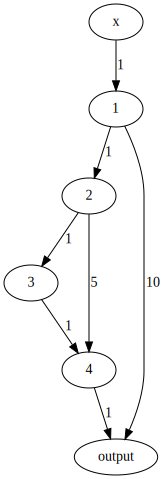

In [77]:
g

In [78]:
## A synthetic Res-Net test

g = graphviz.Digraph()

edges_ex = [('x', '1'), ('1', '2'), ('2', '3'), ('3', '5'), ('5', 'output'), ('1', '4'), ('4', '5')]

weights_ex = {key: 1 for key in set(edges_ex[i][j] for i in range(len(edges_ex)) for j in range(2))}
edges_importance_ex = [1] * len(edges_ex)

for (src, dst), w in zip(edges_ex, edges_importance_ex):
    g.edge(src, dst, label=str(w))


g_nx_ex = nx.DiGraph(edges_ex)
all_sorts_ex = list(nx.all_topological_sorts(g_nx_ex))
print('All sorts', len(all_sorts_ex))
print('-' * 20)
dp_for_top_sort(edges_ex, {k: 1 for k in weights_ex}, edges_importance_ex, all_sorts_ex[2], 4)

# OK, the result is optimal

All sorts 3
--------------------


{'node_to_layer': {'5': 1,
  '4': 0,
  'x': 0,
  '2': 0,
  '1': 0,
  'output': 1,
  '3': 1},
 'pruned_value': 0,
 'pruned_edges': [],
 'connected_graph': True}

In [79]:
x = torch.randn(4, 3, 28, 28)

In [104]:
resnet = ResNet18()
wrapped = torch.fx.symbolic_trace(resnet)
forward_with_gammas(wrapped, {k: 1.0 for k in edges}, x)

Using cache found in /home/legin/.cache/torch/hub/pytorch_vision_v0.10.0


(tensor([[ 1.5393, -1.1505,  0.0684, -0.7406, -0.0153, -1.1178,  1.9337, -0.0725,
           0.0179,  0.2711],
         [ 0.9182, -0.4809, -0.6383,  0.7388,  0.4822,  0.2740,  0.1484, -0.4673,
           0.9845, -1.2977],
         [ 1.3075, -0.2282,  0.6925,  1.2747,  0.0912,  0.3645,  0.7956,  0.2879,
           1.7890,  0.8474],
         [ 0.5630, -1.0756, -0.6426,  0.6258, -0.6342, -1.0569,  0.1678,  0.0291,
          -0.5740, -1.5374]], grad_fn=<MulBackward0>),
 {'x': tensor([[[[-4.4474e-01,  1.0335e+00,  6.9638e-01,  ...,  6.8864e-01,
              1.1283e-01,  1.1839e+00],
            [-1.8809e+00, -1.2141e+00,  7.2780e-01,  ..., -2.0336e-01,
             -8.0049e-01, -1.1974e+00],
            [-1.2983e+00,  1.5877e+00, -6.1385e-01,  ...,  1.6883e+00,
              8.6053e-01, -1.0064e+00],
            ...,
            [-1.0058e+00,  6.2051e-01, -6.5199e-01,  ..., -6.6804e-01,
              1.2377e+00, -6.0876e-01],
            [-1.3367e+00,  5.0591e-01, -8.7967e-02,  ..., -8.871

In [105]:
wrapped(x)

(tensor([[ 1.5393, -1.1505,  0.0684, -0.7406, -0.0153, -1.1178,  1.9337, -0.0725,
           0.0179,  0.2711],
         [ 0.9182, -0.4809, -0.6383,  0.7388,  0.4822,  0.2740,  0.1484, -0.4673,
           0.9845, -1.2977],
         [ 1.3075, -0.2282,  0.6925,  1.2747,  0.0912,  0.3645,  0.7956,  0.2879,
           1.7890,  0.8474],
         [ 0.5630, -1.0756, -0.6426,  0.6258, -0.6342, -1.0569,  0.1678,  0.0291,
          -0.5740, -1.5374]], grad_fn=<AddmmBackward0>),
 {'layer1': tensor([[[[0.6828, 0.8137, 0.4923,  ..., 0.3920, 1.1565, 0.9482],
            [0.7193, 0.9227, 0.2983,  ..., 0.6402, 1.2973, 1.5407],
            [0.6747, 0.5733, 0.1455,  ..., 0.2504, 0.9946, 1.2578],
            ...,
            [0.3431, 0.0519, 0.0000,  ..., 0.3484, 1.3033, 1.0905],
            [0.0724, 0.3566, 0.0000,  ..., 0.2898, 1.0608, 0.7018],
            [0.2178, 0.5862, 0.1375,  ..., 0.3382, 0.5798, 0.3855]],
  
           [[0.3633, 0.5521, 0.1989,  ..., 0.3679, 0.3022, 0.2248],
            [0.2559, 

In [106]:
forward_with_gammas(wrapped, {k: 0.0 for k in edges}, x)

(tensor([[0., 0., -0., 0., 0., -0., 0., -0., -0., -0.],
         [0., 0., -0., 0., 0., -0., 0., -0., -0., -0.],
         [0., 0., -0., 0., 0., -0., 0., -0., -0., -0.],
         [0., 0., -0., 0., 0., -0., 0., -0., -0., -0.]], grad_fn=<MulBackward0>),
 {'x': tensor([[[[-4.4474e-01,  1.0335e+00,  6.9638e-01,  ...,  6.8864e-01,
              1.1283e-01,  1.1839e+00],
            [-1.8809e+00, -1.2141e+00,  7.2780e-01,  ..., -2.0336e-01,
             -8.0049e-01, -1.1974e+00],
            [-1.2983e+00,  1.5877e+00, -6.1385e-01,  ...,  1.6883e+00,
              8.6053e-01, -1.0064e+00],
            ...,
            [-1.0058e+00,  6.2051e-01, -6.5199e-01,  ..., -6.6804e-01,
              1.2377e+00, -6.0876e-01],
            [-1.3367e+00,  5.0591e-01, -8.7967e-02,  ..., -8.8717e-01,
              1.5556e+00, -5.1787e-01],
            [-6.5245e-01,  5.7745e-01,  4.5504e-01,  ...,  1.0216e+00,
             -1.3476e+00,  6.6806e-02]],
  
           [[-7.1033e-01, -4.1657e-01,  1.4940e+00,  ..., 

In [109]:
forward_with_gammas(wrapped, {k: torch.randn(1) for k in edges}, x)

(tensor([[ 0.0026,  0.0094, -0.0066,  0.0113,  0.0017, -0.0084,  0.0038, -0.0135,
          -0.0079, -0.0012],
         [ 0.0016,  0.0082, -0.0051,  0.0126,  0.0012, -0.0088,  0.0041, -0.0125,
          -0.0072,  0.0003],
         [ 0.0028,  0.0098, -0.0057,  0.0108,  0.0022, -0.0085,  0.0046, -0.0135,
          -0.0071,  0.0002],
         [ 0.0010,  0.0083, -0.0067,  0.0126,  0.0018, -0.0090,  0.0050, -0.0128,
          -0.0070, -0.0001]], grad_fn=<MulBackward0>),
 {'x': tensor([[[[-4.4474e-01,  1.0335e+00,  6.9638e-01,  ...,  6.8864e-01,
              1.1283e-01,  1.1839e+00],
            [-1.8809e+00, -1.2141e+00,  7.2780e-01,  ..., -2.0336e-01,
             -8.0049e-01, -1.1974e+00],
            [-1.2983e+00,  1.5877e+00, -6.1385e-01,  ...,  1.6883e+00,
              8.6053e-01, -1.0064e+00],
            ...,
            [-1.0058e+00,  6.2051e-01, -6.5199e-01,  ..., -6.6804e-01,
              1.2377e+00, -6.0876e-01],
            [-1.3367e+00,  5.0591e-01, -8.7967e-02,  ..., -8.871

In [45]:
active_verts = set(list(zip(*edges))[0]) | set(list(zip(*edges))[1])
for g_id, g in enumerate(warp.gammas_name):
    print (g, warp.gammas[g_id].item(), g in active_verts)
    

model_conv1 1.0 True
model_bn1 1.0 True
model_relu 1.0 True
model_maxpool 1.0 True
model_layer1_0_conv1 1.0 True
model_layer1_0_bn1 1.0 True
model_layer1_0_relu 1.0 True
model_layer1_0_conv2 1.0 True
model_layer1_0_bn2 1.0 True
model_layer1_0_relu_1 1.0 True
model_layer1_1_conv1 1.0 True
model_layer1_1_bn1 1.0 True
model_layer1_1_relu 1.0 True
model_layer1_1_conv2 1.0 True
model_layer1_1_bn2 1.0 True
model_layer1_1_relu_1 1.0 True
model_layer2_0_conv1 1.0 True
model_layer2_0_bn1 1.0 True
model_layer2_0_relu 1.0 True
model_layer2_0_conv2 1.0 True
model_layer2_0_bn2 1.0 True
model_layer2_0_downsample_0 1.0 True
model_layer2_0_downsample_1 1.0 True
model_layer2_0_relu_1 1.0 True
model_layer2_1_conv1 1.0 True
model_layer2_1_bn1 1.0 True
model_layer2_1_relu 1.0 True
model_layer2_1_conv2 1.0 True
model_layer2_1_bn2 1.0 True
model_layer2_1_relu_1 1.0 True
model_layer3_0_conv1 1.0 True
model_layer3_0_bn1 1.0 True
model_layer3_0_relu 1.0 True
model_layer3_0_conv2 1.0 True
model_layer3_0_bn2 1.0

[('x',
  'model_conv1',
  'model_bn1',
  'model_relu',
  'model_maxpool',
  'model_layer1_0_conv1',
  'model_layer1_0_bn1',
  'model_layer1_0_relu',
  'model_layer1_0_conv2',
  'model_layer1_0_bn2',
  'model_maxpool',
  'add',
  'model_layer1_0_relu_1',
  'model_layer1_1_conv1',
  'model_layer1_1_bn1',
  'model_layer1_1_relu',
  'model_layer1_1_conv2',
  'model_layer1_1_bn2',
  'model_layer1_0_relu_1',
  'add_1',
  'model_layer1_1_relu_1',
  'model_layer2_0_conv1',
  'model_layer2_0_bn1',
  'model_layer2_0_relu',
  'model_layer2_0_conv2',
  'model_layer1_1_relu_1',
  'model_layer2_0_downsample_0',
  'model_layer2_0_bn2',
  'model_layer2_0_downsample_1',
  'add_2',
  'model_layer2_0_relu_1',
  'model_layer2_1_conv1',
  'model_layer2_1_bn1',
  'model_layer2_1_relu',
  'model_layer2_1_conv2',
  'model_layer2_1_bn2',
  'model_layer2_0_relu_1',
  'add_3',
  'model_layer2_1_relu_1',
  'model_layer3_0_conv1',
  'model_layer3_0_bn1',
  'model_layer3_0_relu',
  'model_layer3_0_conv2',
  'model_